In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [5]:
df.shape

(4026, 7)

In [6]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [8]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [9]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [10]:
y=normalized_df["Period (P)"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

# SVM

In [43]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss
import hyperopt

In [44]:
param_grid_simple={'gamma': hp.uniform('gamma', 0.01, 1),
                   'C':hp.quniform('C',1,10,1)
                  }


In [45]:
def hyperopt_objective(params):
    model=SVR(gamma=int(params['gamma'])
              ,C=int(params['C']))
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))

In [46]:
def param_hyperopt(max_evals=100):
    trials=Trials()
    
    early_stop_fn=no_progress_loss(100) 
    params_best=fmin(hyperopt_objective 
                     ,space=param_grid_simple 
                     ,algo=tpe.suggest 
                     ,max_evals=max_evals 
                     ,trials=trials 
                     ,early_stop_fn=early_stop_fn 
                    )
    
    print('best parmas:',params_best)
    return params_best,trials


In [47]:
def hyperopt_validation(params):
    model=SVR(gamma=int(params['gamma'])
              ,C=int(params['C']))
        
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))

In [48]:
# Start time
start_time = time.time()

params_best, trials = param_hyperopt(100)

hyperopt_validation(params_best)

trials.trials[0]

trials.losses()[:10]
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

100%|██████████| 100/100 [00:41<00:00,  2.39trial/s, best loss: 0.22438759762685412]
best parmas: {'C': 3.0, 'gamma': 0.9312440591879211}
Total time taken:  42.165388345718384


In [49]:
from sklearn.svm import SVR
params_best['C'] = int(params_best['C'])
params_best['gamma'] = int(params_best['gamma'])
svr_reg=SVR(**params_best)
svr_reg.fit(X_train,y_train)

SVR(C=3, gamma=0.93)

In [50]:
y_pred=svr_reg.predict(X_test)
y_pred1=svr_reg.predict(X_val)
y_pred2=svr_reg.predict(X_train)

In [51]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.03738819486092124
mean_squared_error: 0.0021043825235772815
rmse: 0.045873549280356335
r2 score: 0.9577931658257455


In [52]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.03763301455219102
mean_squared_error: 0.002087621842609308
rmse: 0.045690500572978056
r2 score: 0.9573216959905405


In [53]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.03762063523738507
mean_squared_error: 0.0020900226956664524
rmse: 0.045716766023707896
r2 score: 0.9592036770871618


In [54]:
from yellowbrick.regressor import PredictionError

D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


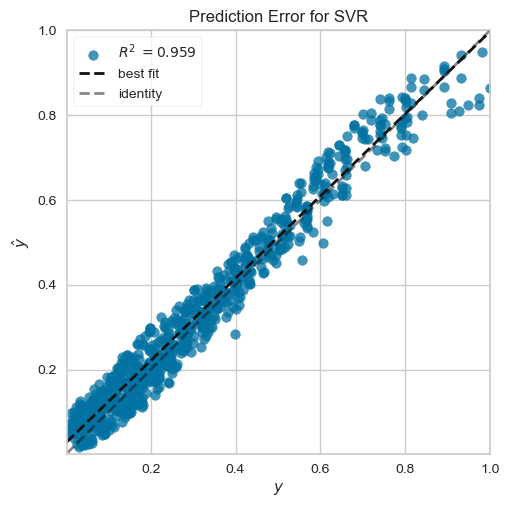

<Axes: title={'center': 'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [55]:
visualizer = PredictionError(svr_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()